In [1]:
!pip install pandas sqlalchemy scikit-learn xgboost skl2onnx onnxruntime duckdb dotenv tabulate lightgbm onnxmltools

In [17]:
pip install --upgrade skl2onnx

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import duckdb
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
import joblib

load_dotenv() 

db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

conn_string = f"dbname={db_name} user={db_user} password={db_password} host={db_host} port={db_port}"

if any(v is None for v in [db_user, db_password, DB_HOST, db_port, db_name]):
    print("ERRO: As variáveis de ambiente não foram carregadas corretamente. Verifique o arquivo 'env'.")
    exit()

con = None
try:
    print("Iniciando conexão DuckDB...")
    con = duckdb.connect(database=':memory:')
    
    con.execute("INSTALL postgres;")
    con.execute("LOAD postgres;")
    print("Extensão PostgreSQL carregada.")
    
    print(f"Tentando ATTACH ao Postgres em {db_host}:{db_port}...")
    con.execute(f"ATTACH $${conn_string}$$ AS postgres_db (TYPE POSTGRES);")
    
    print("DuckDB -> Postgres connection established successfully.")

except Exception as e:
    print(f"ERRO CRÍTICO DE CONEXÃO: {e}")
    print("O kernel pode ter morrido devido a falta de memória (RAM) ou erro de rede/driver.")
    if con:
        con.close()
    raise

Iniciando conexão DuckDB...
Extensão PostgreSQL carregada.
Tentando ATTACH ao Postgres em 172.19.0.1:5432...
DuckDB -> Postgres connection established successfully.


In [3]:
query = """
WITH StatusHistoryFeatures AS (
    SELECT
        tsh.ticket_id,
        COUNT(tsh.history_id) AS status_change_count 
    FROM
        postgres_db.public.ticket_status_history AS tsh
    GROUP BY
        tsh.ticket_id
),
UniqueTicketsFilter AS (
    SELECT
        t.ticket_id,
        ROW_NUMBER() OVER(
            PARTITION BY t.title, t.description 
            ORDER BY t.created_at DESC
        ) as unique_rank
    FROM
        postgres_db.public.tickets AS t
)
SELECT
    t.ticket_id,
    t.created_at,
    t.closed_at,
    sp.resolution_mins, 
    s.name AS subcategory_name,
    c.name AS category_name,
    p.name AS product_name,
    pr.name AS priority_name,
    co.name AS company_name,
    st_curr.name AS current_status_name,
    COALESCE(shf.status_change_count, 0) AS status_change_count,
    d.name AS department_name
FROM
    postgres_db.public.tickets AS t
JOIN
    UniqueTicketsFilter AS utf ON t.ticket_id = utf.ticket_id
JOIN
    postgres_db.public.sla_plans AS sp ON t.sla_plan_id = sp.sla_plan_id
JOIN
    postgres_db.public.subcategories AS s ON t.subcategory_id = s.subcategory_id
JOIN
    postgres_db.public.categories AS c ON s.category_id = c.category_id
JOIN
    postgres_db.public.products AS p ON t.product_id = p.product_id
JOIN
    postgres_db.public.priorities AS pr ON t.priority_id = pr.priority_id
JOIN
    postgres_db.public.companies AS co ON t.company_id = co.company_id
JOIN
    postgres_db.public.statuses AS st_curr ON t.current_status_id = st_curr.status_id
LEFT JOIN
    postgres_db.public.agents AS ag ON t.assigned_agent_id = ag.agent_id
LEFT JOIN
    postgres_db.public.departments AS d ON ag.department_id = d.department_id
LEFT JOIN
    StatusHistoryFeatures AS shf ON t.ticket_id = shf.ticket_id
-- O bloco WHERE deve vir no final, após todos os JOINs
WHERE
    utf.unique_rank = 1
;
"""

try:
    df_raw = con.execute(query).fetchdf()
    print(f"Dados históricos carregados com sucesso: {len(df_raw)} tickets.")
except Exception as e:
    print(f"Error executing query: {e}")
finally:
    try:
        con.close() 
    except:
        pass

Dados históricos carregados com sucesso: 1823 tickets.


In [4]:
df_raw['created_at'] = pd.to_datetime(df_raw['created_at'])
df_raw['closed_at'] = pd.to_datetime(df_raw['closed_at'])

df_raw['created_hour'] = df_raw['created_at'].dt.hour
df_raw['created_day_of_week'] = df_raw['created_at'].dt.dayofweek
df_raw['is_weekend'] = df_raw['created_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

df_history = df_raw.dropna(subset=['closed_at']).copy()

# Tempo de resolução em minutos
df_history['time_to_resolve_minutes'] = (df_history['closed_at'] - df_history['created_at']).dt.total_seconds() / 60
# Target: 1 se estourou (tempo de resolução > resolução de SLA) ou 0 se atendeu
df_history['sla_breach'] = (df_history['time_to_resolve_minutes'] > df_history['resolution_mins']).astype(int)

print(f"Tickets históricos para TREINAMENTO: {len(df_history)}")

features = [
    'resolution_mins', 'created_hour', 'created_day_of_week', 'is_weekend', 
    'status_change_count', # NOVA FEATURE (Comportamento)
    'subcategory_name', 'product_name', 'priority_name', 'department_name',
    'company_name', 'current_status_name' 
]

X = df_history[features]
y = df_history['sla_breach']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Tickets históricos para TREINAMENTO: 238


In [15]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numerical_features = ['resolution_mins', 'created_hour', 'created_day_of_week', 'status_change_count']
categorical_features = ['is_weekend', 'subcategory_name', 'product_name', 'priority_name', 'department_name', 'company_name', 'current_status_name']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

rf_model = RandomForestClassifier(random_state=42)

full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

param_grid = {
    # Número de árvores
    'classifier__n_estimators': [100, 200],
    # Profundidade máxima da árvore
    'classifier__max_depth': [10, 20, None],
    # Mínimo de amostras necessárias para dividir um nó
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    full_pipeline, 
    param_grid, 
    cv=3, 
    scoring='recall',
    verbose=2, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

full_pipeline_optimized = grid_search.best_estimator_

print(f"\n✅ Melhor Recall Encontrado: {grid_search.best_score_:.4f}")
print(f"✅ Melhores Hiperparâmetros: {grid_search.best_params_}")

full_pipeline = full_pipeline_optimized

Iniciando busca por hiperparâmetros (GridSearchCV)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Melhor Recall Encontrado: 1.0000
✅ Melhores Hiperparâmetros: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


In [16]:
# Célula 6: Previsão em Tickets Abertos

# Filtra Tickets Abertos (closed_at é nulo)
df_open = df_raw[df_raw['closed_at'].isnull()].copy() 

X_open = df_open[features] 

df_open['risk_proba'] = full_pipeline.predict_proba(X_open)[:, 1]
print(f"Total de Tickets Abertos para Análise de Risco: {len(df_open)}")

Total de Tickets Abertos para Análise de Risco: 1585


In [17]:
THRESHOLD = 10
global_mean_risk = df_open['risk_proba'].mean()

risk_analysis = df_open.groupby('subcategory_name').agg(
    risk_score_mean=('risk_proba', 'mean'),
    ticket_count=('risk_proba', 'count')
).reset_index()

def smooth_risk(row, global_mean, alpha=5):
    count = row['ticket_count']
    mean_risk = row['risk_score_mean']
    if count < THRESHOLD:
        return (mean_risk * count + global_mean * alpha) / (count + alpha)
    return mean_risk

risk_analysis['normalized_risk_score'] = risk_analysis.apply(
    lambda row: smooth_risk(row, global_mean_risk), axis=1
)

final_report = risk_analysis.sort_values(by='normalized_risk_score', ascending=False)
final_report['normalized_risk_percentage'] = (final_report['normalized_risk_score'] * 100).round(2)

print("\n--- Relatório de Risco de SLA Normalizado (Tickets Abertos) ---")
print(final_report[['subcategory_name', 'ticket_count', 'normalized_risk_percentage']].head(10).to_markdown(index=False))


--- Relatório de Risco de SLA Normalizado (Tickets Abertos) ---
| subcategory_name            |   ticket_count |   normalized_risk_percentage |
|:----------------------------|---------------:|-----------------------------:|
| Funcionalidade indisponível |            186 |                        98.94 |
| Exportação                  |            193 |                        98.83 |
| Cadastro de usuários        |            166 |                        98.7  |
| Dados inconsistentes        |            182 |                        98.67 |
| Lentidão                    |            183 |                        98.62 |
| Problemas de login          |            171 |                        98.28 |
| Erro de sistema             |            180 |                        97.57 |
| Permissões                  |            169 |                        97.07 |
| Relatórios                  |            155 |                        95.72 |



--- Métricas de Avaliação do Modelo ---
Acurácia (Accuracy): 0.9792
Recall (Sensibilidade): 1.0000
F1-Score: 0.9895
--------------------------------------


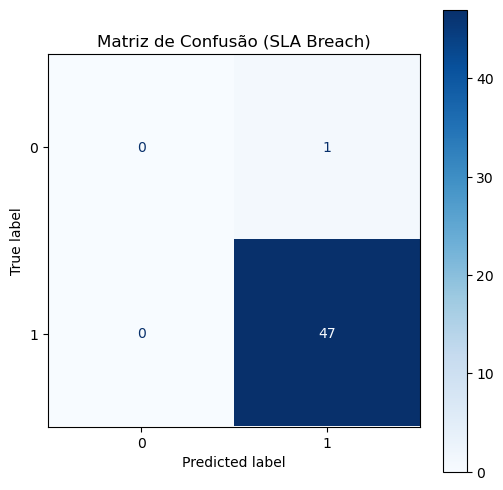


Nota: Para previsão de risco, o Recall (minimizando FN) é a métrica mais importante, pois queremos capturar o máximo de tickets que *realmente* vão estourar.


In [18]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_pred = full_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\n--- Métricas de Avaliação do Modelo ---")
print(f"Acurácia (Accuracy): {accuracy:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("--------------------------------------")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_pipeline.classes_)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Matriz de Confusão (SLA Breach)")
plt.show()

print("\nNota: Para previsão de risco, o Recall (minimizando FN) é a métrica mais importante, pois queremos capturar o máximo de tickets que *realmente* vão estourar.")

In [19]:
# Célula 5A: Salvar o Pré-Processador e Extrair o Modelo
import os
import joblib 

# 1. Salvar o Pré-Processador (ColumnTransformer)
preprocessor_model = full_pipeline.named_steps['preprocessor']
preprocessor_path = 'preprocessor_v2.joblib'
joblib.dump(preprocessor_model, preprocessor_path)
print(f"✅ Pré-processador (ColumnTransformer) salvo em: {preprocessor_path}")

✅ Pré-processador (ColumnTransformer) salvo em: preprocessor_v2.joblib


In [24]:
# Célula 5B: Exportar o Pipeline COMPLETO (Preprocessor + Random Forest) para ONNX (SOLUÇÃO FINAL)

import os
import numpy as np
import pandas as pd
from skl2onnx import to_onnx
from skl2onnx.common.data_types import FloatTensorType, StringTensorType
from sklearn.ensemble import RandomForestClassifier

# --------------------------------------------------------------------------
# 1. Mapeamento de Tipos ONNX
# --------------------------------------------------------------------------
# O to_onnx precisa saber o tipo e o nome de CADA coluna do DataFrame de entrada.
features = [
    'resolution_mins', 'created_hour', 'created_day_of_week', 'is_weekend', 
    'status_change_count', 'subcategory_name', 'product_name', 
    'priority_name', 'department_name', 'company_name', 'current_status_name' 
]

# Definindo o tipo de dado de cada coluna (StringTensorType para categóricas!)
initial_types = [
    # Numéricas (Float)
    ('resolution_mins', FloatTensorType([None, 1])),
    ('created_hour', FloatTensorType([None, 1])),
    ('created_day_of_week', FloatTensorType([None, 1])),
    ('status_change_count', FloatTensorType([None, 1])),
    
    # Categóricas (String)
    ('is_weekend', StringTensorType([None, 1])),
    ('subcategory_name', StringTensorType([None, 1])),
    ('product_name', StringTensorType([None, 1])),
    ('priority_name', StringTensorType([None, 1])),
    ('department_name', StringTensorType([None, 1])),
    ('company_name', StringTensorType([None, 1])),
    ('current_status_name', StringTensorType([None, 1])),
]

# --------------------------------------------------------------------------
# 2. Conversão do Pipeline Completo
# --------------------------------------------------------------------------
try:
    print("Convertendo pipeline COMPLETO (Preprocessor + Random Forest) para ONNX...")

    # A conversão automática do pipeline inteiro
    onnx_model = to_onnx(
        full_pipeline, 
        initial_types=initial_types, # <--- USAMOS O MAPEAMENTO DE TIPOS COMPLETO
        target_opset=15,
        options={"zipmap": False}  
    )
    
    # 2a. Salvamento do Arquivo .onnx
    model_path = 'sla_prediction.onnx'
    with open(model_path, "wb") as f:
        f.write(onnx_model.SerializeToString())
    
    print(f"✅ Pipeline COMPLETO ONNX salvo com sucesso em: {model_path}")
    print("\nInstruções de uso: Carregue o 'sla_prediction.onnx' e passe diretamente o DataFrame original (X) para ele, sem pré-processamento manual.")

except Exception as e:
    print(f"❌ ERRO final ao converter para ONNX: {e}")

Convertendo pipeline COMPLETO (Preprocessor + Random Forest) para ONNX...
✅ Pipeline COMPLETO ONNX salvo com sucesso em: sla_prediction.onnx

Instruções de uso: Carregue o 'sla_prediction.onnx' e passe diretamente o DataFrame original (X) para ele, sem pré-processamento manual.


In [27]:
import numpy as np
import onnxruntime as rt
import pandas as pd
from tabulate import tabulate # Para formatação do output

# Nome do arquivo gerado
MODEL_PATH = 'sla_prediction.onnx'

# As features são as mesmas que você usou no treinamento
features = [
    'resolution_mins', 'created_hour', 'created_day_of_week', 'status_change_count',
    'is_weekend', 'subcategory_name', 'product_name', 
    'priority_name', 'department_name', 'company_name', 'current_status_name'
]

# 1. Preparar Amostra de Teste
# Usamos as primeiras 5 amostras do X_test
X_sample = X_test.head(5) 

# Função para preparar o dicionário de entrada para o ONNX Runtime
def prepare_onnx_input(df_sample):
    input_dict = {}
    
    # Colunas numéricas (devem ser float32, o padrão no ONNX)
    numerical_features = ['resolution_mins', 'created_hour', 'created_day_of_week', 'status_change_count']
    for col in numerical_features:
        # Reshape necessário: (N, 1) e garantir float32
        input_dict[col] = df_sample[col].values.astype(np.float32).reshape(-1, 1) 

    # Colunas categóricas (devem ser arrays de objetos/strings)
    categorical_features = ['is_weekend', 'subcategory_name', 'product_name', 'priority_name', 'department_name', 'company_name', 'current_status_name']
    for col in categorical_features:
        # Reshape necessário: (N, 1) e garantir tipo object (string/categórico)
        # O to_onnx espera o valor da feature, não o índice, por isso o tipo 'object'
        input_dict[col] = df_sample[col].values.astype(object).reshape(-1, 1)

    return input_dict

# 2. Executar Previsão no Modelo ONNX
try:
    print(f"--- Testando Modelo ONNX: {MODEL_PATH} ---")
    
    # Criar sessão de inferência
    sess = rt.InferenceSession(MODEL_PATH, providers=['CPUExecutionProvider'])
    
    # Preparar dados de entrada para o ONNX
    onnx_input = prepare_onnx_input(X_sample)
    
    # Nomes das saídas: o to_onnx define 'output_label' e 'output_probability' por padrão para classificação
    output_names = [output.name for output in sess.get_outputs()]
    
    # Executar a inferência
    onnx_preds = sess.run(output_names, onnx_input)
    
    # Extrair resultados
    onnx_labels = onnx_preds[0] # Saída de rótulos (0 ou 1)
    onnx_probas = onnx_preds[1] # Saída de probabilidades (matriz [N, 2])
    
    print("✅ Previsão ONNX concluída com sucesso.")

except Exception as e:
    print(f"❌ ERRO ao carregar ou executar o modelo ONNX: {e}")
    # Retorna para evitar erro na próxima seção se o ONNX falhou
    raise


# 3. Executar Previsão no Modelo Scikit-learn (Comparação)
print("\n--- Previsão do Modelo Scikit-learn (Original) ---")
skl_labels = full_pipeline.predict(X_sample)
skl_probas = full_pipeline.predict_proba(X_sample)

print("✅ Previsão Scikit-learn concluída com sucesso.")

# 4. Comparação e Resultados
results = []
for i in range(len(X_sample)):
    # Arredondamos as probabilidades para 5 casas decimais para a comparação visual
    skl_proba_breach = round(skl_probas[i][1], 5)
    onnx_proba_breach = round(onnx_probas[i][1], 5)
    
    match_label = skl_labels[i] == onnx_labels[i]
    match_proba = skl_proba_breach == onnx_proba_breach

    results.append({
        "Amostra": i+1,
        "SKL Label": skl_labels[i],
        "ONNX Label": onnx_labels[i],
        "SKL Proba (Breach)": skl_proba_breach,
        "ONNX Proba (Breach)": onnx_proba_breach
    })

print("\n--- Resultado da Comparação (SKL vs ONNX) ---")
print(tabulate(results, headers="keys", tablefmt="pipe"))

--- Testando Modelo ONNX: sla_prediction.onnx ---
✅ Previsão ONNX concluída com sucesso.

--- Previsão do Modelo Scikit-learn (Original) ---
✅ Previsão Scikit-learn concluída com sucesso.

--- Resultado da Comparação (SKL vs ONNX) ---
|   Amostra |   SKL Label |   ONNX Label |   SKL Proba (Breach) |   ONNX Proba (Breach) |
|----------:|------------:|-------------:|---------------------:|----------------------:|
|         1 |           1 |            1 |                 1    |                  1    |
|         2 |           1 |            1 |                 1    |                  1    |
|         3 |           1 |            1 |                 0.97 |                  0.97 |
|         4 |           1 |            1 |                 0.97 |                  0.97 |
|         5 |           1 |            1 |                 0.97 |                  0.97 |
